SYNTHETIC DATASET SUMMARY:
Normal:  312 claims @ $   277/claim
Suspect:  59 claims @ $  1476/claim


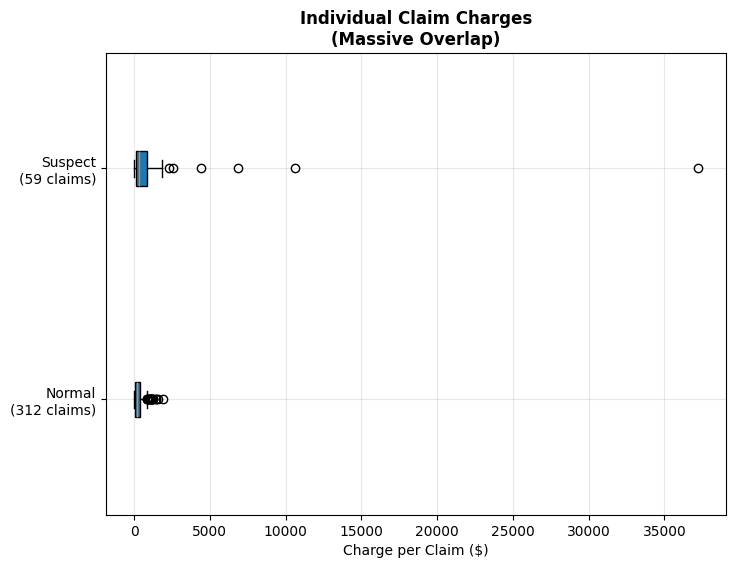

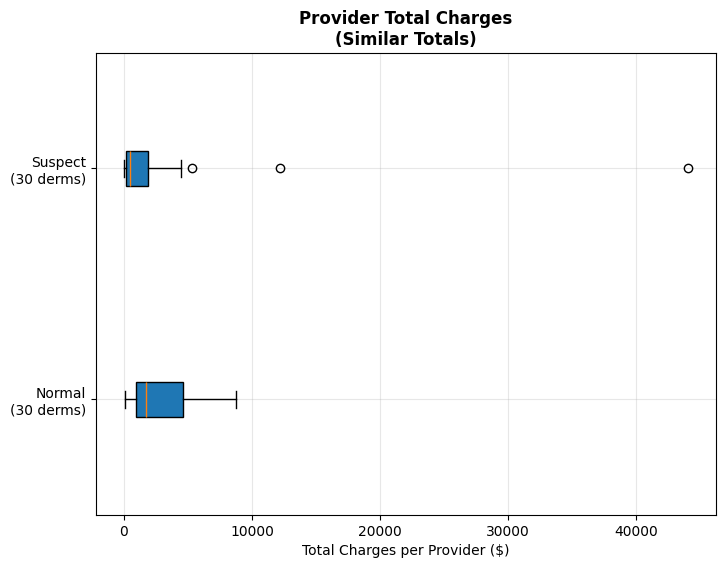


TEST 1: T-TEST (claims independent): t = 1.83, p = 0.0725, SE = $655/claim, df = 58

TEST 2: PROVIDER-LEVEL TEST (clustering preserved): z = 2.05, p = 0.0407, SE = $586/claim

MINIMUM ASSERTABLE OVERBILLING PER CHARGE FOR CLAIMS-LEVEL t-TEST VS PROVIDER-LEVEL TEST
| Confidence | t-test conf. bound | Prov.-level conf. bound | Improvement |
|------------|-------------------|-------------------------|-------------|
| 90%      | $      349 | $              365 | $       16 |
| 95%      | $      103 | $              262 | $      158 |
| 99%      | $     -369 | $              127 | $      inf |

95% CONFIDENCE INTERPRETATION:
• Provider-Level Test: 95% confident suspects overbill by ≥ $262/claim
  → MINIMUM ASSERTABLE overbilling = $262
• t-test:               95% confident suspects overbill by ≥ $103/claim
• IMPROVEMENT: Provider-level test detects $158 MORE overbilling/claim
  → 59 suspect claims × $158 = $9,343 additional recovery

KEY: Correct clustering adjustment reveals 2.0σ fraud si

In [6]:
# Dataset Analysis: Claims-level t-test FAILS vs provider-level test SUCCEEDS at detecting medical upcoding.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 1. GENERATING THE SYNTHETIC CLAIMS DATA 
# =============================================================================

def simulate_derm_dataset(dataset_id: int, n_derms: int = 60, base_date: str = "2023-01-01"):
    n_normal = n_suspect = n_derms // 2
    claims_normal = rng.negative_binomial(6, 0.4, n_normal) + 1
    base_normal = rng.lognormal(5.05, 1.05, n_normal)
    claims_suspect = np.maximum(rng.poisson(2.2, n_suspect), 1)
    base_suspect = rng.lognormal(5.45, 1.35, n_suspect)
    claims = np.concatenate([claims_normal, claims_suspect])
    base_charge_per_claim = np.concatenate([base_normal, base_suspect])
    is_suspect = np.array([0]*n_normal + [1]*n_suspect, dtype=int)
    derm_ids = np.arange(n_derms)
    rows = []
    base_ts = pd.Timestamp(base_date)
    for did, sus, n_claims, cpc in zip(derm_ids, is_suspect, claims, base_charge_per_claim):
        start_day = int(rng.integers(0, 365))
        gap = int(rng.integers(3, 35))
        for k in range(n_claims):
            claim_date = base_ts + pd.Timedelta(days=start_day + k * gap)
            claim_sigma = 0.7 if sus == 0 else 0.85
            claim_charge = np.round(rng.lognormal(np.log(cpc), claim_sigma), 2)
            rows.append((dataset_id, did, claim_date, int(sus), float(claim_charge)))
    return pd.DataFrame(rows, columns=["dataset_id", "derm_id", "claim_date", "is_suspect", "charge"])

# preserved RNG state
state_info = {
    'dataset_id': 363, 'global_rng_seed': 123,
    'rng_state': {'bit_generator': 'PCG64',
                  'state': {'state': 94355403527385315732909144077234208399,
                            'inc': 17686443629577124697969402389330893883},
                  'has_uint32': 0, 'uinteger': 2811114559}
}
rng = np.random.default_rng(state_info['global_rng_seed'])
rng.bit_generator.state = state_info['rng_state']
df = simulate_derm_dataset(state_info['dataset_id'])
df.to_csv('data/synthetic_claims.csv', index=False)

summary = df.groupby('is_suspect')['charge'].agg(['count', 'mean', 'sum']).round(0)
print("SYNTHETIC DATASET SUMMARY:")
print(f"Normal:  {summary.loc[0, 'count']:>3} claims @ ${summary.loc[0, 'mean']:>6.0f}/claim")
print(f"Suspect: {summary.loc[1, 'count']:>3} claims @ ${summary.loc[1, 'mean']:>6.0f}/claim")

# =============================================================================
# 2. EXPLORATORY BOXPLOTS OF NORMAL VS SUSPECT DERMATOLOGISTS
# =============================================================================

normal_charges = df[df.is_suspect == 0]['charge'].values
suspect_charges = df[df.is_suspect == 1]['charge'].values

# PLOT 1: Claim-level
plt.figure(figsize=(8, 6))
plt.boxplot([normal_charges, suspect_charges], 
           labels=[f'Normal\n({len(normal_charges)} claims)', f'Suspect\n({len(suspect_charges)} claims)'], 
           vert=False, patch_artist=True)
plt.title('Individual Claim Charges\n(Massive Overlap)', fontweight='bold')
plt.xlabel('Charge per Claim ($)')
plt.grid(True, alpha=0.3)
plt.savefig('claim_level_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# PLOT 2: Provider-level totals
derm_totals = df.groupby(['derm_id', 'is_suspect'])['charge'].sum().reset_index()
normal_derm = derm_totals[derm_totals.is_suspect == 0]['charge'].values
suspect_derm = derm_totals[derm_totals.is_suspect == 1]['charge'].values

plt.figure(figsize=(8, 6))
plt.boxplot([normal_derm, suspect_derm],
           labels=[f'Normal\n({len(normal_derm)} derms)', f'Suspect\n({len(suspect_derm)} derms)'], 
           vert=False, patch_artist=True)
plt.title('Provider Total Charges\n(Similar Totals)', fontweight='bold')
plt.xlabel('Total Charges per Provider ($)')
plt.grid(True, alpha=0.3)
plt.savefig('provider_level_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# 3. HYPOTHESIS TESTS
# =============================================================================

# T-test 
t_result = stats.ttest_ind(suspect_charges, normal_charges, equal_var=False)
t_stat = t_result.statistic
p_t = t_result.pvalue
df_t = t_result.df
n1, n2 = len(normal_charges), len(suspect_charges)
s1, s2 = np.std(normal_charges, ddof=1), np.std(suspect_charges, ddof=1)
se_t_true = np.sqrt((s1**2/n1) + (s2**2/n2)) # Welch t-test SE (standard error of difference)

print(f"\nTEST 1: T-TEST (claims independent): "
      f"t = {t_stat:.2f}, p = {p_t:.4f}, "
      f"SE = ${se_t_true.item():.0f}/claim, df = {df_t:.0f}")


def provider_level_test(df, B=10000):
    def ratio(group): return group['charge'].sum() / len(group)
    derms = df[['derm_id', 'is_suspect']].drop_duplicates()
    normal_ids = derms[derms.is_suspect == 0]['derm_id'].values
    suspect_ids = derms[derms.is_suspect == 1]['derm_id'].values
    r_normal = ratio(df[df.is_suspect == 0])
    r_suspect = ratio(df[df.is_suspect == 1])
    delta_obs = r_suspect - r_normal
    boot_deltas = np.zeros(B)
    boot_rng = np.random.default_rng(42)
    for b in range(B):
        bs_normal = boot_rng.choice(normal_ids, size=len(normal_ids), replace=True)
        bs_suspect = boot_rng.choice(suspect_ids, size=len(suspect_ids), replace=True)
        bs_df = pd.concat([df[df.derm_id.isin(bs_normal)], df[df.derm_id.isin(bs_suspect)]])
        boot_deltas[b] = ratio(bs_df[bs_df.is_suspect == 1]) - ratio(bs_df[bs_df.is_suspect == 0])
    se_boot = np.std(boot_deltas, ddof=1)
       
    return {
        'r_normal': r_normal, 'r_suspect': r_suspect, 
        'delta_obs': delta_obs, 'se_boot': se_boot,
        'boot_deltas': boot_deltas 
    }
    
# Provider-level test  
provider_results = provider_level_test(df)
z_stat = provider_results['delta_obs'] / provider_results['se_boot']
p_value = 2 * stats.norm.cdf(-abs(z_stat))  # Two-sided

print(f"\nTEST 2: PROVIDER-LEVEL TEST (clustering preserved): "
      f"z = {z_stat:.2f}, p = {p_value:.4f}, SE = ${provider_results['se_boot'].item():.0f}/claim")

# =============================================================================
# 4. LOWER CONFIDENCE BOUNDS ON OVERCHARGE PER CLAIM
# =============================================================================

def one_sided_bootstrap_ci(df, levels=[0.90, 0.95, 0.99], B=10000):
    def ratio(group): return group['charge'].sum() / len(group)
    derms = df[['derm_id', 'is_suspect']].drop_duplicates()
    normal_ids = derms[derms.is_suspect == 0]['derm_id'].values
    suspect_ids = derms[derms.is_suspect == 1]['derm_id'].values
    boot_diffs = np.zeros(B)
    ci_rng = np.random.default_rng(123)
    for b in range(B):
        bs_normal = ci_rng.choice(normal_ids, size=len(normal_ids), replace=True)
        bs_suspect = ci_rng.choice(suspect_ids, size=len(suspect_ids), replace=True)
        bs_df = pd.concat([df[df.derm_id.isin(bs_normal)], df[df.derm_id.isin(bs_suspect)]])
        boot_diffs[b] = ratio(bs_df[bs_df.is_suspect == 1]) - ratio(bs_df[bs_df.is_suspect == 0])
    results = {L: np.percentile(boot_diffs, 100*(1-L)) for L in levels}
    return results

ci_bounds = one_sided_bootstrap_ci(df)

# IMPROVEMENT TABLE
print(f"\n{'='*80}")
print("MINIMUM ASSERTABLE OVERBILLING PER CHARGE FOR CLAIMS-LEVEL t-TEST VS PROVIDER-LEVEL TEST")
print(f"{'='*80}")
print("| Confidence | t-test conf. bound | Prov.-level conf. bound | Improvement |")
print("|------------|-------------------|-------------------------|-------------|")

# Pre-compute t-test critical values for each confidence level
t_crit = {L: abs(stats.t.ppf(L, df_t)) for L in [0.90, 0.95, 0.99]}

for L in [0.90, 0.95, 0.99]:
    t_ci = provider_results['delta_obs'] - t_crit[L] * se_t_true
    p_ci = ci_bounds[L]
    improvement = p_ci - t_ci if p_ci > 0 and t_ci > 0 else float('inf')
    print(f"| {L:.0%}      | ${float(t_ci):>9,.0f} | ${float(p_ci):>17,.0f} | ${float(improvement):>9,.0f} |")

# 95% INTERPRETATION (using corrected values)
print(f"\n{'='*60}")
print(f"95% CONFIDENCE INTERPRETATION:")
p95 = ci_bounds[0.95]
t95 = provider_results['delta_obs'] - t_crit[0.95] * se_t_true
imp95 = p95 - t95
print(f"• Provider-Level Test: 95% confident suspects overbill by ≥ ${p95:,.0f}/claim")
print(f"  → MINIMUM ASSERTABLE overbilling = ${p95:,.0f}")
print(f"• t-test:               95% confident suspects overbill by ≥ ${t95:,.0f}/claim")
print(f"• IMPROVEMENT: Provider-level test detects ${imp95:,.0f} MORE overbilling/claim")
print(f"  → {len(suspect_charges):,} suspect claims × ${imp95:,.0f} = ${imp95*len(suspect_charges):,.0f} additional recovery")
print(f"\nKEY: Correct clustering adjustment reveals {abs(z_stat):.1f}σ fraud signal")


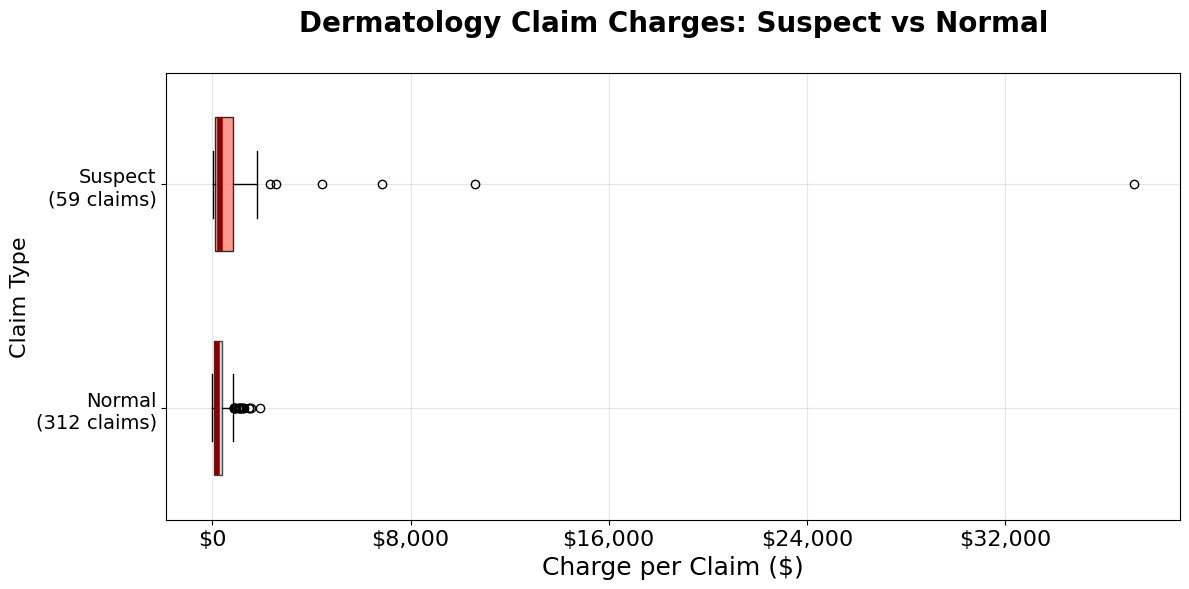

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(12, 6))
bp = plt.boxplot([normal_charges, suspect_charges], 
                 labels=[f'Normal\n({len(normal_charges)} claims)', 
                         f'Suspect\n({len(suspect_charges)} claims)'], 
                 vert=False, patch_artist=True,
                 widths=0.6)  # Taller boxes (default=0.5)

# Color the boxes separately
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor('salmon')       
bp['boxes'][1].set_alpha(0.8)

# Bold median line
for median in bp['medians']:
    median.set(color='darkred', linewidth=4)

plt.title('Dermatology Claim Charges: Suspect vs Normal', 
          fontweight='bold', fontsize=20, pad=30)

plt.xlabel('Charge per Claim ($)', fontsize=18)
plt.ylabel('Claim Type', fontsize=16)

# HUGE tick labels for LinkedIn mobile
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=14)

# Comma-formatted x-axis + fewer ticks
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('linkedin_upcoding_boxplot.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()
